# Probabilistic Matrix Factorization (PMF)

We have a matrix of $N_1$ users who have rated $N_2$ objects (movies). Let us call this matrix M, where $M_{ij}$ contains the rating for user i of object j. PMF is a generatve model in which we assume gaussian distribution for user and object locations and learn the gaussian parameters from the data (matrix). To obtain the parameters of the distribution we need to minimize the log-liklihood:

\begin{equation}
p(M_0, U, V)  = \left[ \prod_{(i,j) \in \Omega} p(M_{ij} | u_i, v_j) \right] x \left[ \prod_{j=1}^{N_2} p(v_j) \right] x \left[ \prod_{i  = 1}^{N_1} p(u_i)\right]
\end{equation}
 


In [3]:
import numpy as np
import numpy.linalg as nplg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

In [4]:
# import data

train = np.genfromtxt ('ratings.csv', delimiter=",")
test = np.genfromtxt ('ratings_test.csv', delimiter=",")

In [5]:
train_matrix = np.zeros((943,1682))

for i in range(train.shape[0]):
    train_matrix[int(train[i][0])-1][int(train[i][1])-1] = train[i][2]

In [7]:
# Since ratings cannot be 0 we replace all nan's with 0s so as to not use them

ind_matrix = train_matrix.copy()
ind_matrix[ind_matrix!=0]=1

In [8]:
def RMSE(u,v,test):
    s=0
    for i in range(test.shape[0]):
        pred=u[int(test[i][0])-1].dot(v[int(test[i][1])-1])
        s+=(pred-test[i][2])**2

    return (s/test.shape[0])**(0.5)

In [28]:

N1 = train_matrix.shape[0]
N2 = train_matrix.shape[1]

# Assume a Gaussian distribution for user and object location vectors
sigma2 = 0.25
d = 10
lam = 1

mean = np.zeros(d)
cov = lam*np.diag(np.ones(d))
objective_all=[]
RMSE_all = []

for runs in range(10):

    # Initialize u and v (Assumption: Gaussian distribution)
    u = np.random.multivariate_normal(mean,cov,N1)
    v = np.random.multivariate_normal(mean,cov,N2) 
    objective=[]

# Coordinate decent for optimizing the log-liklihood

    for itr in range(100):
        
        # Update u
        for i in range(N1):
            sum1 = np.zeros((10,10))
            sum2 = np.zeros(10)

            for j in np.where(ind_matrix[i]==1)[0]:
                sum1 = sum1 + np.outer(v[j],v[j])
                sum2 = sum2 + (train_matrix[i][j])*v[j]

            u[i] = ((nplg.inv(sigma2*cov + sum1)).dot(sum2.reshape(10,1))).flatten()

        # Update v
        for i in range(N2):
            sum1 = np.zeros((10,10))
            sum2 = np.zeros(10)

            for j in np.where(ind_matrix[:,i]==1)[0]:
                sum1 = sum1 + np.outer(u[j],u[j])
                sum2 = sum2 + train_matrix[j][i]*u[j]

            v[i] = ((nplg.inv(sigma2*cov + sum1)).dot(sum2.reshape(10,1))).flatten()

        obj = - np.sum((1.0/(2*sigma2))*np.square(train_matrix - (u.dot(np.transpose(v)))*ind_matrix)) \
              - np.sum((lam/2.0)*np.square(nplg.norm(u,2,1)))- np.sum((lam/2.0)*np.square(nplg.norm(v,2,1)))
            
        objective.append(obj)
        
    # Update best objective function value and corresponding u and v
    if obj_best <= objective[-1]:
        obj_best = objective[-1]
        v_best = v.copy()
        u_best = u.copy()
        
    objective_all.append(objective)
    RMSE_all.append(RMSE(u,v,test))
    
    

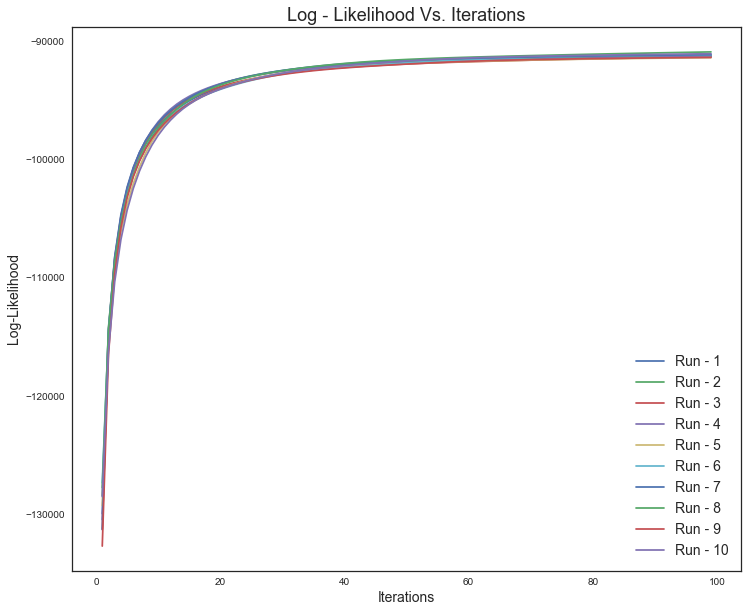

In [24]:
# Plotting convergence of Log-Liklihood with iterations

sns.set_style("white")
plt.figure(figsize=(12,10))
plt.title("Log - Likelihood Vs. Iterations", fontsize = 18)
plt.xlabel("Iterations",fontsize = 14)
plt.ylabel("Log-Likelihood",fontsize = 14)
run=1
for obj in objective_all:    
    plt.plot(range(1,100),obj[1:],label="Run - " + str(run))
    plt.legend(fontsize = 14)
    run=run+1

The log-liklihood starts converging at close to 25-30 iterations

In [30]:
# # RMSE Table
# Sort Objective function by RMSE and store in dataframe

RMSE_all = np.array(RMSE_all)
RMSE_sorted = RMSE_all[np.argsort(RMSE_all)]
objective_all = np.array(objective_all)

RMSE_df = pd.DataFrame()
RMSE_df['Run'] = np.argsort(RMSE_all)+1
RMSE_df['Objective'] = objective_all[np.argsort(RMSE_all),-1].round()
RMSE_df['RMSE'] = RMSE_sorted.round(2)
RMSE_df


,Run,Objective,RMSE
0,6,-91156.0,1.10
1,10,-91052.0,1.11
2,7,-91139.0,1.11
3,2,-91251.0,1.11
4,3,-91308.0,1.12
5,5,-91387.0,1.12
6,8,-90899.0,1.12
7,9,-91366.0,1.13
8,4,-91263.0,1.13
9,1,-91220.0,1.14


#### Run #6 gives the best RMSE of 1.105. 

## Let us look at the movies which are closest to “Star Wars” “My Fair Lady” and “Goodfellas” based on the ratings matrix

In [29]:
## Nearest Movies for  “Star Wars” “My Fair Lady” and “Goodfellas”

# Read movies from txt into a list
with open("./movies.txt") as f:
    content = f.readlines()
    
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 


# Store the index of the movies “Star Wars” “My Fair Lady” and “Goodfellas” in 3 variables
import re
movie1 = "Star Wars"
movie2 = "My Fair Lady"
movie3 = "GoodFellas"

for mv in content:
    if movie1 in mv:
        ind1=content.index(mv)
        
    if movie2 in mv:
        ind2=content.index(mv)
        
    if movie3 in mv:
        ind3=content.index(mv)

# Get Eucledian distance of these 3 movies with all other movies 

dist_SW = []
dist_MFL = []
dist_GF = []

v_SW = v_best[ind1]
v_MFL = v_best[ind2]
v_GF = v_best[ind3]

for vec in v_best:
    dist_SW.append(nplg.norm(v_SW-vec,2)**2)
    dist_MFL.append(nplg.norm(v_MFL-vec,2)**2)
    dist_GF.append(nplg.norm(v_GF-vec,2)**2)

dist_SW = np.array(dist_SW)
dist_MFL = np.array(dist_MFL)
dist_GF = np.array(dist_GF)

content = np.array(content)
top_movies = pd.DataFrame()

# Sort the movies by distances and store in a data frame
content[np.argsort(dist_SW)[1:11]]
dist_SW[np.argsort(dist_SW)[:11]]

top_movies['Star Wars'] = content[np.argsort(dist_SW)[1:11]]
top_movies['Distance (Star Wars)'] = dist_SW[np.argsort(dist_SW)[1:11]].round(2)

top_movies['My Fair Lady'] = content[np.argsort(dist_MFL)[1:11]]
top_movies['Distance (My Fair Lady)'] = dist_MFL[np.argsort(dist_MFL)[1:11]].round(2)

top_movies['GoodFellas'] = content[np.argsort(dist_GF)[1:11]]
top_movies['Distance (GoodFellas)'] = dist_GF[np.argsort(dist_GF)[1:11]].round(2)

top_movies.index = top_movies.index + 1

# Display the dataframe
top_movies

,Star Wars,Distance (Star Wars),My Fair Lady,Distance (My Fair Lady),GoodFellas,Distance (GoodFellas)
1,"Empire Strikes Back, The (1980)",0.09,Mary Poppins (1964),0.41,Once Upon a Time in the West (1969),0.44
2,Raiders of the Lost Ark (1981),0.35,"Sound of Music, The (1965)",0.45,Apocalypse Now (1979),0.65
3,Return of the Jedi (1983),0.37,Sabrina (1954),0.62,Pulp Fiction (1994),0.70
4,"Usual Suspects, The (1995)",0.55,Snow White and the Seven Dwarfs (1937),0.74,"Godfather: Part II, The (1974)",0.70
5,Indiana Jones and the Last Crusade (1989),0.68,Cinderella (1950),0.77,2001: A Space Odyssey (1968),0.86
6,Searching for Bobby Fischer (1993),0.68,Babe (1995),0.80,Cool Hand Luke (1967),0.86
7,Toy Story (1995),0.71,SubUrbia (1997),0.80,Taxi Driver (1976),0.92
8,"Sting, The (1973)",0.75,Gone with the Wind (1939),0.82,Bonnie and Clyde (1967),0.93
9,"Princess Bride, The (1987)",0.79,"Parent Trap, The (1961)",0.87,Gabbeh (1996),0.94
10,"Leading Man, The (1996)",0.83,Little Women (1994),0.89,"Godfather, The (1972)",1.01
